References:
- micrograd on github: https://github.com/karpathy/micrograd
- jupyter notebooks I built in this video: https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd
- my website: https://karpathy.ai
- my twitter:   / karpathy  
- "discussion forum": nvm, use youtube comments below for now :)
- (new) Neural Networks: Zero to Hero series Discord channel:   / discord   , for people who'd like to chat more and go beyond youtube comments

Exercises:
you should now be able to complete the following google collab, good luck!:
https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
# plot the function
xs = np.arange(-25, 25, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

$$
f'(x)= \frac{dy}{dx} = \lim_{{h \to 0}} \frac{f(x+h)-f(x)}{h}
$$

In [ ]:
h = 0.001
x = 2/3
(f(x + h) - f(x))/h

In [ ]:
# lets look at a more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

In [ ]:
# calculate the derivatives of d wrt a, b and c
def set_inputs(s):
    print("\n" + "*" * len(s))
    print(s)
    print("*" * len(s))
    h = 0.0001
    a = 2.0
    b = -3.0
    c = 10.0
    d = a*b + c
    return h, a, b, c, d

# d' wrt a
h, a, b, c, d = set_inputs("d' wrt a")
a += h
d2 = a*b + c

print("d1", d)
print("d2", d2)
print("d' wrt a = \t", (d2-d)/h)

# d' wrt b
h, a, b, c, d = set_inputs("d' wrt b")
b += h
d2 = a*b + c
print("d1", d)
print("d2", d2)
print("d' wrt b = \t", (d2-d)/h)

# d' wrt c
h, a, b, c, d = set_inputs("d' wrt c")
c += h
d2 = a*b + c
print("d1", d)
print("d2", d2)
print("d' wrt c = \t", (d2-d)/h)


In [ ]:
# Let's build a skeleton for the neural net
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None  # default grad 
        self._prev = set(_children)    # for efficiency?
        self._op = _op
        self.label = label
        
    def __repr__(self):                # python will use this to return the string
        return f"Value(data={self.data})"
    
    def __add__(self, other):          # python internally does a + b # <=> a.__add__(b)
        other = other if isinstance(other, Value) else Value(other) # Handle the case where other is not anobject
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __neg__(self): # - self
        return self * -1   

    def __sub__(self, other): # self - other
        return self  + (-other)   

    def __rsub__(self, other): # self - other
        return -self + other   
    
    
    def __mul__(self, other):        # python internally does a * b # <=> a.__mul__(b)
        other = other if isinstance(other, Value) else Value(other) # Handle the case where other is not anobject
        out = Value(self.data * other.data, (self, other), '*')
            
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self/other
        return self * other ** -1    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}' )

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t ** 2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            x = self.data
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
    

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

In [ ]:
d._prev

In [ ]:
a = Value(2.0)
1- a + 1

In [ ]:
a = Value(2.0)
a.exp()

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

In [ ]:
d._op

In [ ]:
# visualization
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
draw_dot(L)

In [ ]:
L = d * f
# dL/df = d
# dL/dd = f

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
# ------------------------
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
# ------------------------
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0
# ------------------------
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
# ------------------------
# re-run the forward pass!
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d*f; L.label = 'L'
print(L.data)

In [ ]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    #     
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

<!-- Back propagate on a neuron -->
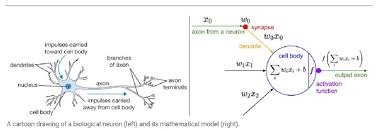

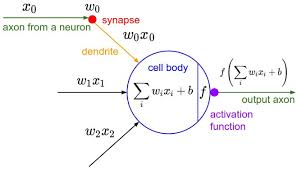

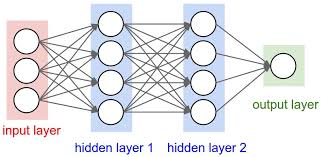

f is an activation function, that could be a sigmoid or tanh function

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid(); plt.show()

In [ ]:
# inputs, x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b;  n.label= 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

$$ \tanh(x)  = \frac{e^{2x} -1}{e^{2x} +1}$$

In [ ]:
# inputs, x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b;  n.label= 'n'
# -------
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
# Example; bug!
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
# Another example:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

In [ ]:
# Lets do back prop manually
o.grad = 1.0

# d tanh(x)/dx = 1 - tanh^2(x)
n.grad = 1.0 - o.data**2

# a '+' is only a distributer
b.grad = n.grad
x1w1x2w2.grad = 1.0 * n.grad

# another '+'
x1w1.grad = 1.0 * n.grad
x2w2.grad = 1.0 * n.grad

# now we have a '*'
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

# ... and similarly 
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [ ]:
# Now let's do back prop automaticallay. Order matters => topological ordering.
# Set the base case to 1.0. dx/dx = 1
o.grad = 1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward() # nothing happens; its a leaf function

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
#  The order above is important.
# Lets implement tological ordering
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

In [ ]:
# Lets do the same thing using pytorch

In [ ]:
import torch
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True # leaf nodes do not require gradient by default for effiency  => set to true 
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
o.item()

In [ ]:
# torch s based around tensors, higher dimensional arrays

In [ ]:
# Let's start building the neural network

<!-- Building a 2 layer mlp -->
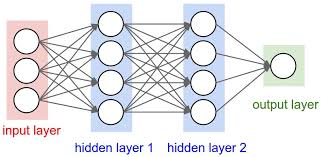

In [ ]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x): 
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)),  self.b)
        out = act.tanh()
        return out
    
    def parameters(self):           # gather the parameters of the nweuron
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x): 
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):           # gather the parameters of the layer
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts): # nouts contains a list of length of layers
        sz = [nin]  + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range (len(nouts))]
    
    def __call__(self, x): 
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):           # gather the parameters of the MLP
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1]
# n = Neuron(2)
# n(x)
n = MLP(3, [4, 4, 1]) # 3 inputs, two layers of 4 and one output
n(x)

In [ ]:
draw_dot(n(x))

In [ ]:
# How to apply back prop. Simple classifier example
xs = [
    [2.0, 3.0, -1.0], # outputs 1.0
    [3.0, -1.0, 0.5], # outputs -1.0
    [0.5, 1.0, 1.0],  # outputs -1.0
    [1.0, 1.0, -1.0], # outputs 1.0
]

ys = [1.0, -1.0, -1.0, 1.0] # desired

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]  # what does the nn thinks of the above
    
    # evaluate the loss, usually cross entropy loss instead of th means square error
    loss = sum((ygt - yout) ** 2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters(): # like we do in the grad
        p.grad = 0.0
        
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += - 0.05 * p.grad
    
    print(k, loss.data)
    
ypred
# n.parameters()